In [ ]:
:!pip install keras_tuner
!pip install simplemma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import io
import os
import re
import shutil
import string
import pandas as pd
import nltk
import simplemma
import utils

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import TextVectorization, Dense, Embedding, GlobalAveragePooling1D, LSTM, Dropout

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Definition of a Transformer block

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, l2_value=1e-6):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [
                layers.Dense(ff_dim, activation="relu",kernel_regularizer=regularizers.l2(l2_value)),
                layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(l2_value)),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Preprocessing

In [ ]:
train = pd.read_csv("../subtaskA_train_set.csv")
val = pd.read_csv("../subtaskA_val_set.csv")
test = pd.read_csv("../subtaskA_test_set.csv")
trainval = pd.read_csv("../subtaskA_trainval_set.csv")

## Definition of vocabulary and tokenizer

Spiegazione utile su embeddings
https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

In [ ]:
def create_vocab_data(sentences):
  vocab = []
  for sentence in sentences:
    # lowercase sentence
    sentence = sentence.lower()
    # strip punctuation
    sentence = re.sub('\W+', ' ', sentence)
    # split by whitespace
    tokens = sentence.split(" ")

    for token in tokens:
      if token != "" and token != " ":
        vocab.append(simplemma.lemmatize(token, lang=("it", "en")))

  l = list(set(vocab))
  if "" in l:
    l.remove('')
  return l

In [ ]:
vocab_data = create_vocab_data(train["comment_text"].array)
vocab_size = len(vocab_data) + 2
sequence_length = 256

# Use the text vectorization layer to normalize, split, and map strings to integers.
vectorize_layer = TextVectorization(
  standardize="lower_and_strip_punctuation",
  split="whitespace",
  vocabulary=vocab_data,
  max_tokens=vocab_size,
  output_mode='int',
  output_sequence_length=sequence_length)

# Training of the model

## Model definition

In [ ]:
def get_model_with_hp(embedding_dim, num_heads, ff_dim, dense_layer_units, dropout_rate, l2_value, learning_rate, clipnorm):
  # defining inputs
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')

  # Vectorize layer
  net = vectorize_layer(text_input)

  # Embedding layer
  net = Embedding(vocab_size, embedding_dim, name="embedding")(net)

  # Transformer
  net = TransformerBlock(embedding_dim, num_heads, ff_dim, dropout_rate, l2_value)(net)
  net = Dropout(dropout_rate)(net)
  net = GlobalAveragePooling1D()(net)

  # Fully connected layers
  net = Dense(dense_layer_units, name = "fully_connected_layer_1")(net)
  net = Dropout(dropout_rate)(net)

  net = Dense(dense_layer_units, name = "fully_connected_layer_2")(net)
  net = Dropout(dropout_rate)(net)

  net = Dense(dense_layer_units, name = "fully_connected_layer_3")(net)
  net = Dropout(dropout_rate)(net)

  # Output layer
  net = Dense(
      units=1,
      activation="sigmoid",
      name="output_classifier"
  )(net)

  model = tf.keras.Model(text_input, net)

  optimizer = Adam(
    learning_rate = learning_rate,
    clipnorm = clipnorm
  )

  model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics='accuracy'
  )

  return model

def get_model(hp):
  return get_model_with_hp(
    embedding_dim = hp.Choice("Embedding dimension", values=[16, 32, 64]),
    num_heads = hp.Choice("attention heads", values=[2,4,6]),
    ff_dim = hp.Choice("ff dim", values=[16,32]),
    dense_layer_units = hp.Choice("dense layer units", values = [8, 16, 32]),
    dropout_rate = 0.10,
    l2_value = hp.Choice("L2 regularization", values=[1e-6]),
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3]),
    clipnorm = 0.1
  )


## Random search

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=get_model,
    max_trials=8,
    objective='val_accuracy',
    overwrite=True
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=5e-2,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=1e-3,
    min_lr=1e-5
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='auto',
    patience=20,
    verbose=False,
    restore_best_weights=True
)

In [ ]:
tuner.search(
    x = train["comment_text"],
    y = train["conspiratorial"],
    epochs = 70,
    validation_data = (val["comment_text"], val["conspiratorial"]),
    callbacks = [
        reduce_lr,
        early_stopping
    ]
)

Trial 8 Complete [00h 01m 45s]
val_accuracy: 0.7680723071098328

Best val_accuracy So Far: 0.8132529854774475
Total elapsed time: 00h 18m 03s


In [ ]:
tuner.get_best_hyperparameters(1)[0].values

{'Embedding dimension': 32,
 'attention heads': 2,
 'ff dim': 32,
 'dense layer units': 8,
 'L2 regularization': 1e-06,
 'learning_rate': 0.001}

## Final train of the model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
best_model = get_model_with_hp(
    embedding_dim = 32,
    num_heads = 2,
    ff_dim = 32,
    dense_layer_units = 8,
    dropout_rate = 0.1,
    l2_value = 1e-6,
    learning_rate = 1e-3,
    clipnorm = 0.5,
)

history = best_model.fit(
    x = train["comment_text"],
    y = train["conspiratorial"],
    epochs=60,
    validation_data = (val["comment_text"], val["conspiratorial"]),
    batch_size = 256,
    callbacks= [
      tf.keras.callbacks.TensorBoard(log_dir="logs"),
      reduce_lr,
      #early_stopping
    ]
)


Epoch 1/60
6/6 [==============================] - 8s 263ms/step - loss: 0.7413 - accuracy: 0.5162 - val_loss: 0.6751 - val_accuracy: 0.5693 - lr: 0.0010
Epoch 2/60
6/6 [==============================] - 1s 191ms/step - loss: 0.6770 - accuracy: 0.5630 - val_loss: 0.6612 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 3/60
6/6 [==============================] - 1s 188ms/step - loss: 0.6787 - accuracy: 0.5494 - val_loss: 0.6559 - val_accuracy: 0.6657 - lr: 0.0010
Epoch 4/60
6/6 [==============================] - 1s 188ms/step - loss: 0.6596 - accuracy: 0.5977 - val_loss: 0.6550 - val_accuracy: 0.5904 - lr: 0.0010
Epoch 5/60
6/6 [==============================] - 1s 194ms/step - loss: 0.6542 - accuracy: 0.6294 - val_loss: 0.6487 - val_accuracy: 0.6777 - lr: 0.0010
Epoch 6/60
6/6 [==============================] - 1s 191ms/step - loss: 0.6375 - accuracy: 0.6543 - val_loss: 0.6450 - val_accuracy: 0.5994 - lr: 0.0010
Epoch 7/60
6/6 [==============================] - 1s 223ms/step - loss: 0.6366 - a

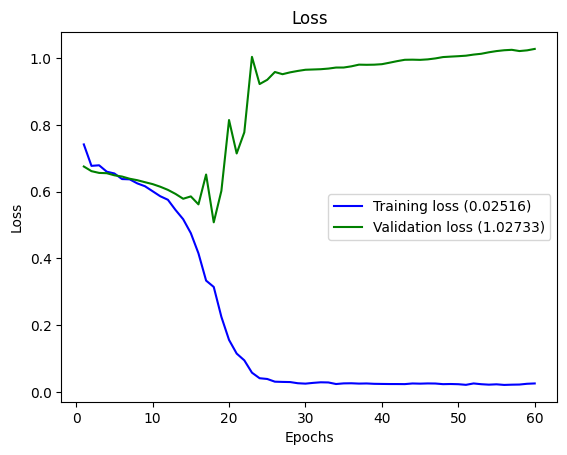

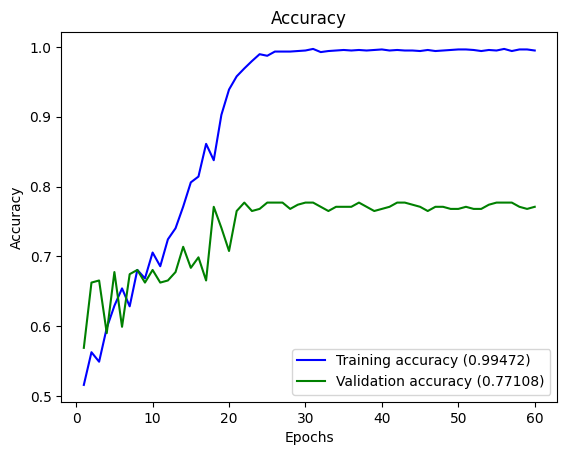

In [ ]:
utils.plot_history(history)

In [ ]:
best_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 32)           293184    
                                                                 
 transformer_block_8 (Transf  (None, 256, 32)          10656     
 ormerBlock)                                                     
                                                                 
 dropout_50 (Dropout)        (None, 256, 32)           0         
                                                                 
 global_average_pooling1d_8   (None, 32)               0   

# Test phase

In [ ]:
final_model = get_model_with_hp(
    embedding_dim = 32,
    num_heads = 2,
    ff_dim = 32,
    dense_layer_units = 8,
    dropout_rate = 0.1,
    l2_value = 1e-6,
    learning_rate = 1e-3,
    clipnorm = 0.5,
)

history = final_model.fit(
    x = train["comment_text"],
    y = train["conspiratorial"],
    batch_size=256,
    epochs=20
)

Epoch 1/20
7/7 [==============================] - 9s 181ms/step - loss: 0.7407 - accuracy: 0.4906
Epoch 2/20
7/7 [==============================] - 1s 170ms/step - loss: 0.6624 - accuracy: 0.5914
Epoch 3/20
7/7 [==============================] - 1s 180ms/step - loss: 0.6488 - accuracy: 0.6343
Epoch 4/20
7/7 [==============================] - 1s 181ms/step - loss: 0.6513 - accuracy: 0.6174
Epoch 5/20
7/7 [==============================] - 1s 169ms/step - loss: 0.6310 - accuracy: 0.6536
Epoch 6/20
7/7 [==============================] - 1s 172ms/step - loss: 0.6242 - accuracy: 0.6542
Epoch 7/20
7/7 [==============================] - 1s 212ms/step - loss: 0.6131 - accuracy: 0.6789
Epoch 8/20
7/7 [==============================] - 2s 264ms/step - loss: 0.5888 - accuracy: 0.7085
Epoch 9/20
7/7 [==============================] - 1s 163ms/step - loss: 0.5638 - accuracy: 0.7357
Epoch 10/20
7/7 [==============================] - 2s 246ms/step - loss: 0.5326 - accuracy: 0.7592
Epoch 11/20
7/7 [==

In [ ]:
_ = final_model.evaluate(
    x = test["comment_text"],
    y = test["conspiratorial"],
    batch_size=256
)

1/1 [==============================] - 1s 641ms/step - loss: 1.1209 - accuracy: 0.7676


6/6 [==============================] - 0s 11ms/step


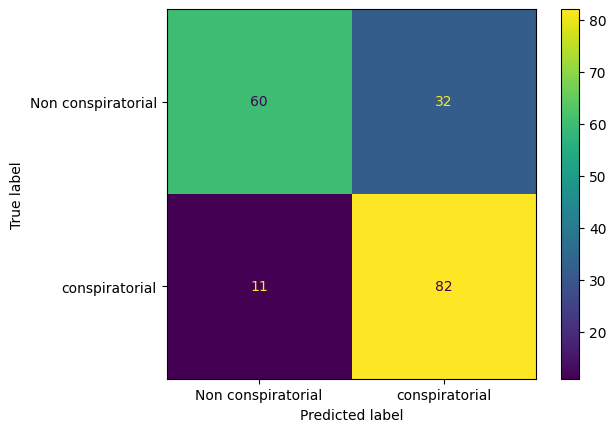

In [ ]:
predictions = final_model.predict(x=test["comment_text"])
predictions = list(map(round, [ _[0] for _ in predictions]))

cm = confusion_matrix(test["conspiratorial"], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non conspiratorial", "conspiratorial"])
disp.plot()